# Detector Baseline Comparison

In [1]:
import sys
import numpy as np
import wfdb

sys.path.append("..")

from raccoon.detectors import GarciaBerdonesDetector, SarlijaDetector, XiangDetector
from raccoon.utils.annotationutils import trigger_points
from raccoon.utils.evaluationutils import triggers_metrics, sensitivity, f1, ppv

Using TensorFlow backend.


## Load Data

In [2]:
def read_record(path, sampto=None):
    record = wfdb.rdrecord(path, sampto=sampto)
    annotation = wfdb.rdann(path, 'atr', sampto=sampto)
    trigger = trigger_points(annotation)
    return record, trigger

def read_records(directory, names, sampto=None):
    records, triggers = [], []
    for name in names:
        path = "/".join([directory, name])
        record, trigger = read_record(path, sampto)
        records.append(record)
        triggers.append(trigger)
    return records, triggers

In [3]:
# Clean ECG Signals
signal_dir = "../data/mitdb"
names = np.array(["100", "101", "102", "103", "104", "105", "106", "107", "108", "109"])
sampto = 10000

records, triggers = read_records(signal_dir, names, sampto)
records, triggers = np.array(records), np.array(triggers)

# Noise template
noise_path = '../data/noises/em'
noise_template = wfdb.rdrecord(noise_path)

## Add Noise

In [4]:
from raccoon.utils.noiseutils import apply_noise_db

records = [
    apply_noise_db(record, noise_template, 6)
    for record in records]

records = np.array(records)

## Define Experiment Setups

In [5]:
from collections import defaultdict

gd = defaultdict(int)
gd['name'] = "Garcia-Berdones et al. (1997)"
gd['detector'] = GarciaBerdonesDetector(
    name='GD', batch_size=32, window_size=20, epochs=1)

xd = defaultdict(int)
xd['name'] = "Xiang et al. (2018)"
xd['detector'] = XiangDetector(
    name='XD', batch_size=32, window_size=40, detection_size=20, aux_ratio=5, epochs=1)

experiments = [gd, xd]

## Train and Test

In [6]:
from contextlib import redirect_stdout
from io import StringIO
from sklearn.model_selection import LeaveOneOut

loo = LeaveOneOut()

for train_indexes, test_indexes in loo.split(names):
    train_records = records[train_indexes]
    train_triggers = triggers[train_indexes]
    
    test_records = records[test_indexes]
    test_triggers = triggers[test_indexes]
    
    print(f"Training with {names[train_indexes]}.")
    print(f"Testing with {names[test_indexes]}.")
    print(f"QRS complexes to be found: {len(test_triggers[0])}.")

    for experiment in experiments:
        detector = experiment['detector']
        detector.reset()
        with redirect_stdout(StringIO()):
            detector.train(train_records, train_triggers)
        detected = detector.detect(test_records)
        tp, tn, fp, fn = triggers_metrics(test_triggers, detected, 5)
        experiment["tp"] += tp
        experiment["tn"] += tn
        experiment["fp"] += fp
        experiment["fn"] += fn
        print(f"{experiment['name']}: {(tp, tn, fp, fn)}")
    
    print()

Training with ['101' '102' '103' '104' '105' '106' '107' '108' '109'].
Testing with ['100'].
QRS complexes to be found: 35.
Garcia-Berdones et al. (1997): (27, 0, 3, 8)
Xiang et al. (2018): (34, 0, 0, 1)

Training with ['100' '102' '103' '104' '105' '106' '107' '108' '109'].
Testing with ['101'].
QRS complexes to be found: 32.
Garcia-Berdones et al. (1997): (32, 0, 0, 0)
Xiang et al. (2018): (32, 0, 0, 0)

Training with ['100' '101' '103' '104' '105' '106' '107' '108' '109'].
Testing with ['102'].
QRS complexes to be found: 34.
Garcia-Berdones et al. (1997): (4, 0, 20, 30)
Xiang et al. (2018): (33, 0, 1, 1)

Training with ['100' '101' '102' '104' '105' '106' '107' '108' '109'].
Testing with ['103'].
QRS complexes to be found: 32.
Garcia-Berdones et al. (1997): (32, 0, 0, 0)
Xiang et al. (2018): (32, 0, 0, 0)

Training with ['100' '101' '102' '103' '105' '106' '107' '108' '109'].
Testing with ['104'].
QRS complexes to be found: 35.
Garcia-Berdones et al. (1997): (20, 0, 11, 15)
Xiang et

## Calculate Statistics

In [7]:
for experiment in experiments:
    tp, fp, fn = experiment["tp"], experiment["fp"], experiment["fn"]
    experiment["se"] = sensitivity(tp, fn)
    experiment["ppv"] = ppv(tp, fp)
    experiment["f1"] = f1(tp, fp, fn)

## Plot

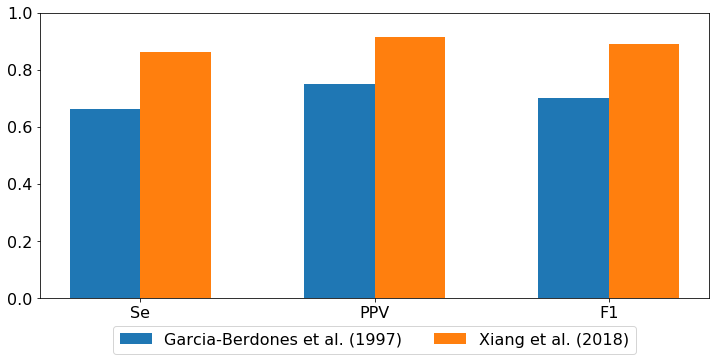

In [14]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots()
fig.set_size_inches(12, 7)

bar_width = 0.6 / len(experiments)
index = np.arange(3) # Se, PPV, F1

for offset, e in enumerate(experiments):
    ax.bar(
        index+offset*bar_width,
        [e['se'], e['ppv'], e['f1']],
        bar_width,
        label=e['name'])

ax.set_xticks(index + 0.5*bar_width)
ax.set_xticklabels(('Se', 'PPV', 'F1'))
ax.set_ylim(0, 1)

# Shrink current axis's height by 25% on the bottom
box = ax.get_position()
ax.set_position([
    box.x0, box.y0 + box.height * 0.25,
    box.width, box.height * 0.75])

# Put a legend below current axis
ax.legend(
    loc='upper center', bbox_to_anchor=(0.5, -0.07), ncol=2)

plt.show()

In [15]:
save = True

if save:
    fig.savefig(
        '../../msc-thesis/thesis/images/detectors_baseline.pdf',
        format='pdf',
        bbox_inches = 'tight',
        pad_inches = 0.1)